# Tracking the genealogy during forward simulation

This tutorial will cover several use cases of `tskit` for forward simulations.  We start with a simple Wright-Fisher simulation with no selection and no recomination, and gradually increase the complexity of our examples until we are recording mutations, ancient samples, and associated meta-data.

The code used here is written in Python3.  However, the logic will apply to a simulation written in any language where `tskit` is used for simplification.

## Conventions used

The following markups will appear in this document.  They represent some of the "wisdom" accumulated when writing and debugging simulations using `tskit/msprime`.

**Pro tip:** refers to an advanced concept to keep in mind when developing/testing your own simulations.

**Detail:** refers to a technical detail about implementation choices made here.  These details may or may not be general.

**Gotcha:** refers to something non-intuitive that can lead to subtle bugs.

A sub-section titled "Technical notes" will contain long-winded **Pro tip** entries.  Please feel free to skip these during a first reading.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import SVG
import msprime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
msprime.__version__

'0.5.0b3.dev10+g1296d0a'

## Definitions

Before we can make any progress, we require a few definitions.  We will focus on the case of diploids, but the concepts used here generalize to any ploidy. Actually, things generalize to any mixtures of ploidys if you are willing to do the book-keeping!

A *node* is used to label the birth time of a lineage.  A node can be described by a tuple, `(id, time)`, where `id` is unique and `time` reflects the birth time of that `id`. A *diploid* is a pair of nodes.

For the case of the discrete-time Wright-Fisher (WF) model, if $N$ individuals currently exist at time point $t$, then there are $2N$ nodes, $[i,i+2N)$, and the diploids are defined as tuples grouping pairs of adjacent nodes, $D \in [(i,i+1),(i+2,i+3),\dots,(2N-2,2N-1)]$, where each $(i,j)$ pairing is a diploid.

An *edge* reflects a transmission event between nodes.  An edge is a tuple `(left, right, parent, child)` whose meaning is "Parent $P$ passed on the genomic interval $[l,r)$ to child $C$".

The goal of this tutorial is to work through the book-keeping required to generate nodes and edges forwards in time and "simplify" them into the minimal set of nodes and edges that describe the history of the sample.

All of our simulations will follow the parameter scaling laid out by Dick Hudson's `ms` software, which is also used in `mspms`, a command-line script that is part of [msprime](https://github.com/jeromekelleher/msprime).

We also need to define what we mean by time, which is simple for the discrete-time model.  A simulation will start at generation 0, which consists of $2N$ parental nodes (nodes $[0,2N)$) and no edges. We will simulate forwards in time for $g$ generations, starting with $g = 1$ (the first offspring generation).  In generation $g$, we will add nodes with `id` values $[2Ng,2N(g+1))$ and `time` value $g$ to the `NodeTable`.

The simplification algorithm works with respect to a *sample*.  Here, a sample will refer to the most recent generation simulated *plus* any ancient samples that are being tracked.

## A Wright-Fisher simulation with no recombination

Here, we simulate a constant-sized Wright-Fisher population of $N$ _diploid_ individuals with no mutation, no recombination, and no selection.  We generate nodes and edges as we go, simplify once at the end, and add mutations with msprime.

The mechanics of transmission in this case are simple.  Each generation simply adds $2N$ more nodes to a `NodeTable` and $2N$ edges to an `EdgeTable` (one for each paretal gamete).  In the absence of recombination, an offspring inherits the interval $[0,1)$ from each of two parental nodes.  To generate an offspring, we pick two parents, and then one node from each parent, and create edges reflecting the transmission.

The simulation is shown in the following function:

In [3]:
def wf1(N, ngens):
    """
    Constant-sized WF model with no mutation, no recombination, no selection,
    and no simplification.
    """
    nodes, edges = msprime.NodeTable(), msprime.EdgeTable()
    
    # Add 2N nodes at time = 0.
    # These nodes represent the 
    # initial list of parental
    # gametes
    for i in range(2*N):
        nodes.add_row(time=0)
    
    next_offspring_index = len(nodes)
    first_parental_index = 0
    for gen in range(1,ngens+1):
        assert(next_offspring_index == len(nodes))
        assert(first_parental_index == len(nodes) - 2*N)
        # Pick 2N parents
        parents = np.random.randint(0, N, 2*N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            # Pick 1 gamete from each parent
            mendel = np.random.random_sample(2)
            g1 = first_parental_index + 2*parent1 + (mendel[0] < 0.5)
            g2 = first_parental_index + 2*parent2 + (mendel[1] < 0.5)

            # Add nodes for our offspring's
            # two gametes
            nodes.add_row(time=float(gen))
            nodes.add_row(time=float(gen))
  
            # Add edges reflecting the
            # transmission from parental
            # nodes to offspring nodes
            edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
            edges.add_row(left=0.0, right=1.0, parent=g2, child=next_offspring_index+1)
            
            next_offspring_index += 2
            
        first_parental_index += 2*N
        
    return (nodes,edges)

Let's run the simulation, simulating 100 diploids for 1,000 generations:

In [4]:
np.random.seed(42)
nodes, edges = wf1(100,1000)

### Simplifying the output

First, we have to convert time from forwards to backwards, and reset the node table accordingly.

**Detail:** We also set the "flags" to 1 for each node, marking it as a sample.

In [5]:
t = nodes.time
t -= t.max()
t *= -1.0
flags = np.ones(len(nodes),dtype=np.uint32)
nodes.set_columns(time=t,flags=flags)

Our "samples" will be all nodes from the last generation simulated, which is now the nodes with `time` equal to 0.0.

In [6]:
samples=np.where(nodes.time == 0.0)[0]

We are now ready to sort, simplify, and load tables:

In [7]:
msprime.sort_tables(nodes=nodes,edges=edges)
node_map = msprime.simplify_tables(samples=samples.tolist(),nodes=nodes,edges=edges)
ts = msprime.load_tables(nodes=nodes,edges=edges)

Let's take a look at the result:

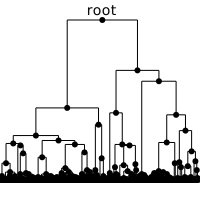

In [8]:
SVG(next(ts.trees()).draw(height=200,width=200, node_labels={len(ts.tables.nodes)-1:'root'}))

The `node_map` returned from the simplify function is the same length as our input (un-simplified) node table.  Each element has a value of -1 if the input node is not an output node (e.g., it was "simplified out" of the final data), otherwise it contains the index of the node in the simplified node table.  Let's look at the relationship between the indexes for the final generation before and after simplification:

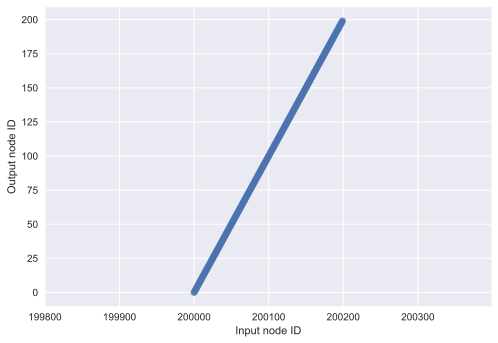

In [9]:
p = sns.regplot(x=samples,y=node_map[samples],fit_reg=False)
p.set(xlabel="Input node ID",ylabel="Output node ID");

The above figure is quite important: when we simplify with respect to the *last* generation simulated, those nodes become the *first* nodes in the simplified tables!  The reason is because our simplified tables represent time from the present to the past.  The implication is that our simple book-keeping of `next_offspring_index` and `first_parental_index` will be less simple when we apply the simplification step *during* a forward simulation instead of once at the end.

**Pro tip:** note the perfectly linear relationship betwee input node id and output node id in the above figure.  The simplification algorithm *preserves input order of sample nodes*, which is something we'll need to keep in mind later when handling ancient samples.

## Adding regular simplification

Here, we implement the WF simulation with simplification happening at regular intervals.  It is helpful to think of this as regular "garbage collection", as what we're really doing is getting rid of extinct lineages while also "trimming" extant lineages down to a minimal representation.

**Gotcha:** Regular garbage collection forces us to reckon with the figure from the previous section, which shows us that simplification remaps the input sample IDs to `[0,len(samples))`.  This remapping affects how we update the values of *both* `next_offspring_index` and `next_parental_index`.  See the comments in the implementation below.

First, we need to move our simplification code into a separate scope, as we call it from multiple points of our simulation:

In [135]:
def simplify_nodes_edges(nodes,edges,temp_nodes,dt):
    """
    :param nodes (msprime.NodeTable): All nodes simplified so far
    :param edges (msprime.EdgeTable): All edges simplified so far
    :param temp_nodes (msprime.NodeTable): All new nodes since the last simplification happened.
    :param dt (int): The number of generations since the last simplification
    """
    if len(edges) == 0:
        # This is a guard for the case of simplifying every generation.
        # This function will be called when generation the first
        # set of offspring, at which point the edges will be empty,
        # and attempting to simplify empty EdgeTables results
        # in an exception
        return nodes,edges
    
    # "Push" existing nodes dt generations further back into the past:
    nodes.set_columns(time=nodes.time+float(dt),flags=nodes.flags)
    
    # Reverse direction of time for our new nodes:
    t = temp_nodes.time
    t -= t.max()
    t *= -1.0
    
    # Append new nodes to old nodes, sort, simplify:
    nodes.append_columns(time=t,flags=np.ones(len(temp_nodes),dtype=np.uint32))
    msprime.sort_tables(nodes=nodes,edges=edges)
    samples = np.where(nodes.time == 0.0)[0]
    node_map = msprime.simplify_tables(samples=samples.tolist(),nodes=nodes,edges=edges)
    
    # Assert that the plot shown in the previous section always holds true.
    assert(all(node_map[samples] == np.arange(len(samples),dtype=node_map.dtype)))
    return nodes,edges

Our new simulation will return a tuple of *simplified* nodes and edges:

In [151]:
def wf2(N, ngens, gc):
    """
    Constant-sized WF model with no mutation, no recombination, no selection,
    and no simplification.
    
    :param N (int): Diploid population size
    :param ngens (int): Number of generations to simulate
    :param gc (int): "Garbage collection" interval, or how often to simplify the data.
    
    :rtype: tuple
    
    :returns: A simplified tuple, (msprime.NodeTable, msprime.EdgeTable)
    """
    if gc < 1:
        raise ValueError("gc must be a non-negative int")
        
    nodes, edges = msprime.NodeTable(), msprime.EdgeTable()
    temp_nodes = msprime.NodeTable()
    # Add 2N nodes at time = 0.
    # These nodes represent the 
    # initial list of parental
    # gametes
    for i in range(2*N):
        nodes.add_row(time=0)
    
    next_offspring_index = len(nodes)
    first_parental_index = 0
    last_gc_time = 0
    for gen in range(1,ngens+1):
        if (gen) % gc == 0.0:
            # Simplify the data
            nodes,edges = simplify_nodes_edges(nodes,edges,temp_nodes,gen-last_gc_time)
            last_gc_time=gen
            
            # Empty out our temp node table
            temp_nodes.reset()
            
            # len(nodes) has been changed by simplification.
            # Node ids are [0,len(nodes)), implying
            # the following value for the next offspring
            # index:
            next_offspring_index = len(nodes)
            
            # The node ids from the last generation simulated
            # have been remapped to start at 0, which is the 
            # value of the first valid parent:
            first_parental_index = 0
            assert(all(nodes.time[:2*N] == 0.0))
        else:
            # If we have NOT simplified the data, 
            # then we have appended 2N new nodes to the end of
            # nodes.  Thus, the last 2N nodes are the potential
            # parents of the next generation.  Since
            # next_offspring_index is set to the correct value,
            # we can simply use that as our baseline:
            first_parental_index = next_offspring_index - 2*N
            
            # The following may be useful to know. len(nodes)
            # is the current length of all simplified nodes so far.
            # len(temp_nodes) is the length of any new nodes added
            # since the last simplification.  Thus, the sum of the
            # two NodeTables gives a second way to calculate
            # first_parental_index:
            assert(first_parental_index == len(nodes)+len(temp_nodes)-2*N)
            
        # Pick 2N parents
        parents = np.random.randint(0, N, 2*N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            # Pick 1 gamete from each parent
            mendel = np.random.random_sample(2)
            g1 = first_parental_index + 2*parent1 + (mendel[0] < 0.5)
            g2 = first_parental_index + 2*parent2 + (mendel[1] < 0.5)

            # Add nodes for our offspring's
            # two gametes
            temp_nodes.add_row(time=float(gen))
            temp_nodes.add_row(time=float(gen))
  
            # Add edges reflecting the
            # transmission from parental
            # nodes to offspring nodes
            edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
            edges.add_row(left=0.0, right=1.0, parent=g2, child=next_offspring_index + 1)
            
            next_offspring_index += 2

    if len(temp_nodes)>0:
        # Handle any new nodes before returning
        simplify_nodes_edges(nodes, edges, temp_nodes, gen + 1 - last_gc_time)

    return (nodes,edges)

### Invariance to simplification interval

A critical concept to keep in mind is that the simulation itself is the only random component.  The simplification algorithm is deterministic *given a set of (nodes, edges) satisfying msprime/tskit's sorting requirements*.

Therefore, the results of our `wf2` function must be the same for all simplification intervals:

In [150]:
np.random.seed(42)
n, e = wf2(100,1000, 1)

# Iterate over a range of 
# odd and even simplification
# intervals.
for i in range(2,1000,33):
    # Make sure each new sim
    # starts with same random seed!
    np.random.seed(42)
    ni, ei = wf2(100, 1000, i)
    assert(n == ni)
    assert(e == ei)

**Pro tip**: testing your own code using loops like the one above is a very good way to identify subtle bugs in book-keeping.

**Detail:** the results of `wf1` will *not* be the identical to those from `wf2` because our book-keeping of parent/offspring indexes differs.  Results over many simulation replicates will be the same *in distribution*, however.

**Gotcha:** The book-keeping of `first_parental_index` is still rather simple here due to keeping $N$ constant.  Arbitrary variation in $N$ over time doesn't change any of the concepts, but it does force you to do some more book-keeping.

### Summary

* Simplifying during a simulation changes the rules for how we generate new node IDs and track the parent/offspring node ID relationship.

* When simplifying regularly, we need to "push" existing simplified nodes further back in time.

* Our code to simplify NodeTable and EdgeTable instances gets called in two different parts of our simulation.  When we're in that situation, we should offload the work to a class or function for easier code re-use and for testing.

#### Technical notes

* We have found that it is possible to write a simulation where the results differ by simplification interval, but appear correct in distribution.  By this we mean that looking at distributions of numbers of mutations, their frequencies, etc., match predictions from analytical theory.  However, our experience is that such simulations contain bugs and that the summaries being used for testing are too crude to catch them.  For example, they may affect the variance in a subtle way that would require millions of simulations to catch.  Often what is going on is that parent/offspring relationships are not being properly recorded, resulting in lineages that either persist too long or not long enough.  (In other words, the variance in offspring number per diploid is no longer what it should be, meaning you've changed the effective population size.) Thus, please make sure you get the **same** NodeTable and EdgeTable out of a simulation for any simplification interval.